# Analysis of cyclooctane conformational space with $\texttt{LieDetect}$

Henrique Hennes https://github.com/HLovisiEnnes \
Raphaël Tinarrage https://raphaeltinarrage.github.io/

See the repo at https://github.com/HLovisiEnnes/LieDetect and the article at https://arxiv.org/abs/2309.03086

- **I. Conformers not aligned**
- **II. Conformers aligned**

In [1]:
# Third-party imports.
import numpy as np
import sklearn, scipy
import gudhi
import matplotlib.pyplot as plt
# import py3Dmol, rdkit, rdkit.Chem.rdDistGeom, rdkit.Chem.rdMolAlign
import rdkit.Chem.rdDistGeom, rdkit.Chem.rdMolAlign

# Local imports.
from orbits import sample_orbit_from_algebra
from liepca import get_lie_pca_operator, print_covariance_eigenvalues, orthonormalize
from optimization import find_closest_algebra

In [2]:
def discard_outliers(pts, n_neighbors=50, contamination=0.1):
    clf = sklearn.neighbors.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    y_pred = clf.fit_predict(pts)
    return pts[y_pred == 1, :], y_pred


def classification_linkage(pts, n_clusters=2, method='single'):
    pairwise_distances = scipy.cluster.hierarchy.distance.pdist(pts)
    linkage = scipy.cluster.hierarchy.linkage(pairwise_distances, method=method)
    idx_to_cluster_array = scipy.cluster.hierarchy.fcluster(linkage, n_clusters, criterion='maxclust')
    clusters = idx_to_cluster_array - 1
    return clusters

# I. Conformers not aligned

Initial point cloud has shape (24903, 24)
Subsampled point cloud has shape (10000, 24)
Covariance eigenvalues: 4.7e-01  4.6e-01  1.2e-02  1.2e-02  7.5e-03  7.2e-03  6.3e-03  6.2e-03  5.9e-03  2.4e-03  2.3e-03  1.9e-03  1.8e-03  1.5e-03  1.2e-03  1.1e-03  4.6e-04  4.5e-04  4.2e-04  4.1e-04  2.5e-04  2.4e-04  1.8e-04  1.1e-04 


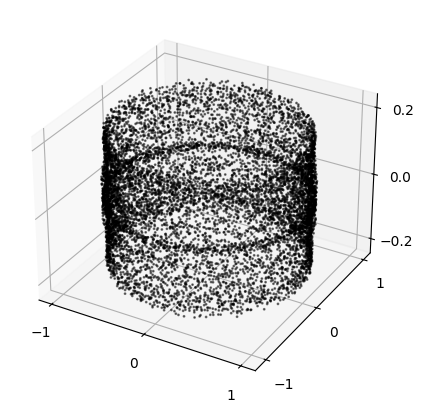

In [3]:
' Define point cloud '

# Parameters.
hydrogens = False  # whether to add hydrogens coordinates
nb_conformers = 50000  # initial number of conformers generated
nb_conformers_subsample = 10000  # subsampled number of conformers

# Select a molecule.
smiles = 'C1CCCCCCC1'  # cyclooctane
# smiles = 'CC(C(=O)NC(C)C(=O)O)N'  # L-Alanyl-L-alanine
# smiles = 'CCCCC'  # pentane
# smiles = 'OC(=O)C(Cc1ccccc1)NC(=O)C2CCCN2'  # Prolylphenylalanine
# smiles = 'CCCC'  # butane
# smiles = 'C1CCCCC1'  # cyclohexane
# smiles = 'CCCCC1CCCCCCC1'  # Butylcyclooctane
# smiles = 'C1CCCCCC(=O)CCCCC1'  # Cyclododecanone

# Generate conformers.
m = rdkit.Chem.MolFromSmiles(smiles)
m = rdkit.Chem.AddHs(m)
cids = rdkit.Chem.rdDistGeom.EmbedMultipleConfs(m, numConfs=nb_conformers, numThreads=-1, useExpTorsionAnglePrefs=False)

# Remove hydrogens.
if not hydrogens: m = rdkit.Chem.RemoveHs(m)

# Select only one chirality cluster
pts = np.array([conformer.GetPositions().flatten() for conformer in m.GetConformers()])
pts, _ = discard_outliers(pts, contamination=0.01)
clusters = classification_linkage(pts, n_clusters=2)
pts = pts[clusters == 0, :]
print('Initial point cloud has shape', np.shape(pts))

# Center and normalize
pts = pts - np.mean(pts, 0)
pts /= np.mean([np.linalg.norm(pts[i, :]) for i in range(np.shape(pts)[0])])

# Subsample with gudhi
pts = np.array(gudhi.subsampling.choose_n_farthest_points(points=pts, nb_points=nb_conformers_subsample))
print('Subsampled point cloud has shape', np.shape(pts))

# Print covariance eigenvalues.
print_covariance_eigenvalues(pts)

# Plot point cloud
pts_pca = sklearn.decomposition.PCA(n_components=3).fit_transform(pts)
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c='black', s=1, alpha=0.5)
plt.locator_params(nbins=4)
plt.show()
fig.savefig('figures/cyclooctane1.png', dpi=fig.dpi, bbox_inches='tight')

Covariance eigenvalues: 2.5e-01  2.5e-01  2.5e-01  2.5e-01 
Covariance eigenvalues: 2.8e-01  2.7e-01  2.2e-01  2.2e-01 


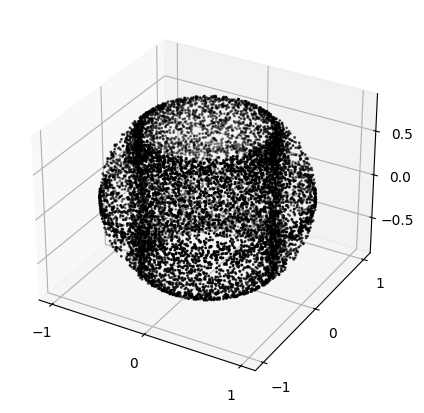

In [4]:
' Normalize data '

# Project in smaller dimension.
ambient_dim = 4
pts_dim_red = sklearn.decomposition.PCA(n_components=ambient_dim).fit_transform(pts)

# Orthonormalization.
pts_dim_red, _ = orthonormalize(pts_dim_red)
print_covariance_eigenvalues(pts_dim_red)

# Normalize pointwise.
pts_dim_red = np.array([x / np.linalg.norm(x) for x in pts_dim_red])
print_covariance_eigenvalues(pts_dim_red)

# Plot point cloud.
pts_dim_red_pca = sklearn.decomposition.PCA(n_components=3).fit_transform(pts_dim_red)
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.scatter(pts_dim_red_pca[:, 0], pts_dim_red_pca[:, 1], pts_dim_red_pca[:, 2], c='black', s=1)
plt.locator_params(nbins=4)
plt.show()

Point cloud after outliers removal has shape (8500, 4)
Selected cluster has shape (7512, 4)


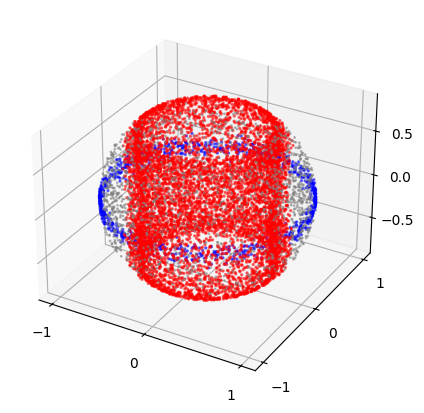

In [5]:
' Extract torus component '

# Outliers removal and hierarchical clustering.
pts_rem, pts_pred = discard_outliers(pts_dim_red, contamination=0.15)
print('Point cloud after outliers removal has shape', np.shape(pts_rem))
clusters = classification_linkage(pts_rem, n_clusters=2, method='single')

# Define cluster.
i_cluster = np.argmax([np.sum(clusters == 0), np.sum(clusters == 1)])
pts_cluster = pts_rem[clusters == i_cluster, :]
print('Selected cluster has shape', np.shape(pts_cluster))

# Plot clusters and outliers.
indices_not_outlier = np.where(pts_pred == 1)[0]
indices_outlier = np.where(pts_pred == -1)[0]
indices_cluster_0 = indices_not_outlier[clusters == 0]
indices_cluster_1 = indices_not_outlier[clusters == 1]
pts_dimred_pca = sklearn.decomposition.PCA(n_components=3).fit_transform(pts_dim_red)
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.locator_params(nbins=4)
ax.scatter(pts_dimred_pca[indices_outlier, 0], pts_dimred_pca[indices_outlier, 1], pts_dimred_pca[indices_outlier, 2],
           c='grey', s=1, alpha=0.5)
ax.scatter(pts_dimred_pca[indices_cluster_0, 0], pts_dimred_pca[indices_cluster_0, 1],
           pts_dimred_pca[indices_cluster_0, 2], c='blue', s=2, alpha=0.5)
ax.scatter(pts_dimred_pca[indices_cluster_1, 0], pts_dimred_pca[indices_cluster_1, 1],
           pts_dimred_pca[indices_cluster_1, 2], c='red', s=2, alpha=0.5)
fig.savefig('figures/cyclooctane2.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()

Lie PCA first eigenvalues: 1.5e-02  2.4e-02  1.1e-01  1.2e-01  Eigengap #2: 4.7e+00.


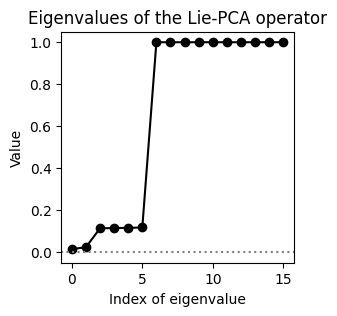

In [6]:
' Lie PCA '

# Compute Lie PCA operator.
dim = 2
n_neighbors = 50
method = 'localPCA'
lie_pca = get_lie_pca_operator(pts=pts_cluster, nb_neighbors=n_neighbors, orbit_dim=dim, method="PCA", correction=True,
                               verbose=True)

# Plot its eigenvalues.
vals = np.sort(np.linalg.eigvals(lie_pca).real)
_, ax = plt.subplots(figsize=(3, 3))
ax.plot(range(len(vals)), vals, c="black")
ax.scatter(range(len(vals)), vals, c="black")
ax.axhline(0, color="grey", linestyle="dotted")
ax.set_ylim((0 - 0.05, max(vals) + 0.05))
ax.set_title("Eigenvalues of the Lie-PCA operator")
ax.set_xlabel("Index of eigenvalue")
ax.set_ylabel("Value")
fig.savefig('figures/cyclooctane3.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()

----> Optimization problem via abelian method for torus  <----
The optimal rep found is ((0, -1), (-1, 0)) with cost 6.844e-16.
Non-symmetric Hausdorff distance from point cloud to estimated orbit: 0.1724
Non-symmetric Hausdorff distance from estimated orbit to point cloud: 0.1047


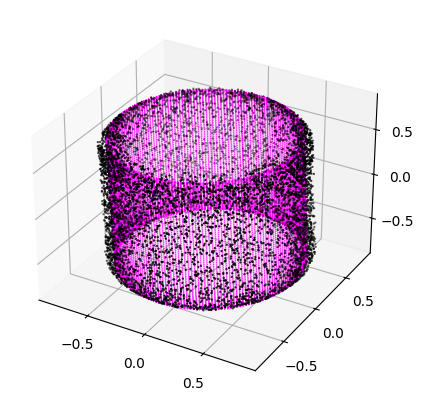

In [7]:
' LieDetect '

# Find frequencies
frequency_max = 1
optimal_rep, optimal_algebra = find_closest_algebra(group="torus", lie_pca=lie_pca, group_dim=dim,
                                                    frequency_max=frequency_max, span_ambient_space=True,
                                                    method="abelian", verbose=True)
' Optimize initial point '

# Find best initial point
nb_points_orbit = 10 ** 2
distances = list()
for i in range(len(pts_cluster)):
    # Generate estimated orbit
    x = pts_cluster[i, :]
    orbit = sample_orbit_from_algebra(group="torus", rep_type=optimal_rep, algebra=optimal_algebra, x=x,
                                      nb_points=nb_points_orbit, method="uniform", verbose=False)

    # Compute non-symmetric Hausdorff
    hausdorff1 = scipy.spatial.distance.directed_hausdorff(pts_cluster, orbit)[0]
    hausdorff2 = scipy.spatial.distance.directed_hausdorff(orbit, pts_cluster)[0]
    distances.append(max(hausdorff1, hausdorff2))

# Generate estimated orbit
nb_points_orbit = 200 ** 2
x = pts_cluster[np.argmin(distances), :]
orbit = sample_orbit_from_algebra(group="torus", rep_type=optimal_rep, algebra=optimal_algebra, x=x,
                                  nb_points=nb_points_orbit, method="uniform", verbose=False)

# Compute non-symmetric Hausdorff
hausdorff = scipy.spatial.distance.directed_hausdorff(pts_cluster, orbit)[0]
print('Non-symmetric Hausdorff distance from point cloud to estimated orbit:', round(hausdorff, 4))
hausdorff = scipy.spatial.distance.directed_hausdorff(orbit, pts_cluster)[0]
print('Non-symmetric Hausdorff distance from estimated orbit to point cloud:', round(hausdorff, 4))

# Plot orbit.
pca = sklearn.decomposition.PCA(n_components=3).fit(pts_cluster)
pts_cluster_pca = pca.transform(pts_cluster)
orbit_pca = pca.transform(orbit)
_, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.scatter(pts_cluster_pca[:, 0], pts_cluster_pca[:, 1], pts_cluster_pca[:, 2], c="black", s=0.4)
ax.scatter(orbit_pca[:, 0], orbit_pca[:, 1], orbit_pca[:, 2], c='magenta', s=0.1, alpha=0.75, marker="3")
plt.locator_params(nbins=4)
plt.show()
fig.savefig('figures/cyclooctane4.png', dpi=fig.dpi, bbox_inches='tight')

# II. Conformers aligned

Initial point cloud has shape (50000, 24)
Subsampled point cloud has shape (10000, 24)
Covariance eigenvalues: 2.4e-01  2.4e-01  1.3e-01  1.2e-01  9.8e-02  5.8e-02  5.7e-02  2.0e-02  2.0e-02  4.4e-03  3.0e-03  2.9e-03  2.6e-03  2.3e-03  3.9e-04  3.7e-04  1.9e-04  1.6e-04  1.1e-12  6.4e-13  1.7e-16  2.1e-17  -1.9e-17  -6.3e-17 


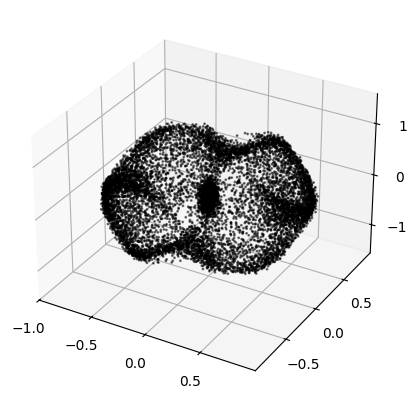

In [8]:
' Define point cloud '

# Align the conformers.
rdkit.Chem.rdMolAlign.AlignMolConformers(m)

# Get the atoms position.
pts = np.array([conformer.GetPositions().flatten() for conformer in m.GetConformers()])
print('Initial point cloud has shape', np.shape(pts))

# Center and normalize.
pts = pts - np.mean(pts, 0)
pts /= np.mean([np.linalg.norm(pts[i, :]) for i in range(np.shape(pts)[0])])

# Subsample with gudhi.
pts = np.array(gudhi.subsampling.choose_n_farthest_points(points=pts, nb_points=nb_conformers_subsample))
print('Subsampled point cloud has shape', np.shape(pts))

# Print eigenvalues.
print_covariance_eigenvalues(pts)

# Plot point cloud.
pts_pca = sklearn.decomposition.PCA(n_components=3).fit_transform(pts)
ax.view_init(elev=15, azim=30)
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c='black', s=1, alpha=0.5)
plt.locator_params(nbins=4)
plt.show()
fig.savefig('figures/cyclooctane1_align.png', dpi=fig.dpi, bbox_inches='tight')

Point cloud after outliers removal has shape (9000, 24)
Selected cluster has shape (8228, 24)


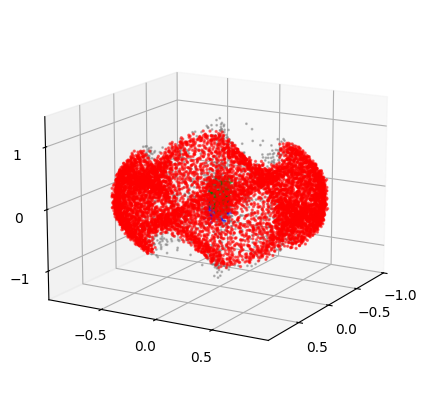

Covariance eigenvalues: 2.9e-01  2.9e-01  2.1e-01  2.1e-01 


In [9]:
' Extract torus component '

pts_dim_red = pts

# Outliers removal and hierarchical clustering.
pts_rem, pts_pred = discard_outliers(pts_dim_red, contamination=0.1)
print('Point cloud after outliers removal has shape', np.shape(pts_rem))
clusters = classification_linkage(pts_rem, n_clusters=3, method='single')

# Define cluster
i_cluster = np.argmax([np.sum(clusters == 0), np.sum(clusters == 1), np.sum(clusters == 2)])
pts_cluster = pts_rem[clusters == i_cluster, :]
print('Selected cluster has shape', np.shape(pts_cluster))

# Plot clusters and outliers.
indices_not_outlier = np.where(pts_pred == 1)[0]
indices_outlier = np.where(pts_pred == -1)[0]
indices_cluster_0 = indices_not_outlier[clusters == 0]
indices_cluster_1 = indices_not_outlier[clusters == 1]
Indices_cluster_2 = indices_not_outlier[clusters == 2]
pca = sklearn.decomposition.PCA(n_components=3).fit(pts_rem)
pts_dimred_pca = pca.transform(pts_dim_red)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.locator_params(nbins=4)
ax.view_init(elev=15, azim=30)
ax.scatter(pts_dimred_pca[indices_outlier, 0], pts_dimred_pca[indices_outlier, 1], pts_dimred_pca[indices_outlier, 2],
           c='grey', s=1, alpha=0.5)
ax.scatter(pts_dimred_pca[indices_cluster_0, 0], pts_dimred_pca[indices_cluster_0, 1],
           pts_dimred_pca[indices_cluster_0, 2], c='blue', s=2, alpha=0.5)
ax.scatter(pts_dimred_pca[indices_cluster_1, 0], pts_dimred_pca[indices_cluster_1, 1],
           pts_dimred_pca[indices_cluster_1, 2], c='green', s=2, alpha=0.5)
ax.scatter(pts_dimred_pca[Indices_cluster_2, 0], pts_dimred_pca[Indices_cluster_2, 1],
           pts_dimred_pca[Indices_cluster_2, 2], c='red', s=2, alpha=0.5)
fig.savefig('figures/cyclooctane2_align.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()

# Dimension reduction.
ambient_dim = 4
pts_cluster = sklearn.decomposition.PCA(n_components=ambient_dim).fit_transform(pts_cluster)

# Orthonormalization.
pts_cluster, _ = orthonormalize(pts_cluster)

# Normalize pointwise
pts_cluster = np.array([x / np.linalg.norm(x) for x in pts_cluster])
print_covariance_eigenvalues(pts_cluster)

Lie PCA first eigenvalues: 1.5e-02  5.1e-02  5.2e-02  1.0e-01  Eigengap #2: 1.0e+00.


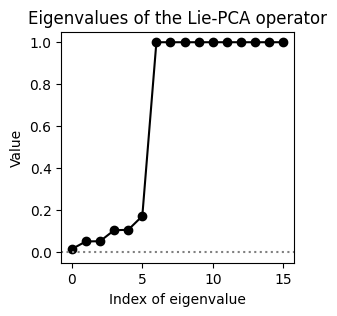

In [10]:
' Lie PCA '

# Compute Lie PCA operator.
dim = 2
n_neighbors = 50
method = 'localPCA'
lie_pca = get_lie_pca_operator(pts=pts_cluster, nb_neighbors=n_neighbors, orbit_dim=dim, method="PCA", correction=True,
                               verbose=True)

# Plot its eigenvalues.
vals = np.sort(np.linalg.eigvals(lie_pca).real)
_, ax = plt.subplots(figsize=(3, 3))
ax.plot(range(len(vals)), vals, c="black")
ax.scatter(range(len(vals)), vals, c="black")
ax.axhline(0, color="grey", linestyle="dotted")
ax.set_ylim((0 - 0.05, max(vals) + 0.05))
ax.set_title("Eigenvalues of the Lie-PCA operator")
ax.set_xlabel("Index of eigenvalue")
ax.set_ylabel("Value")
fig.savefig('figures/cyclooctane3_align.png', dpi=fig.dpi, bbox_inches='tight')
plt.show()

----> Optimization problem via abelian method for torus  <----
The optimal rep found is ((0, -1), (-1, 0)) with cost 0.000e+00.
Non-symmetric Hausdorff distance from point cloud to estimated orbit: 1.0722
Non-symmetric Hausdorff distance from estimated orbit to point cloud: 0.4404


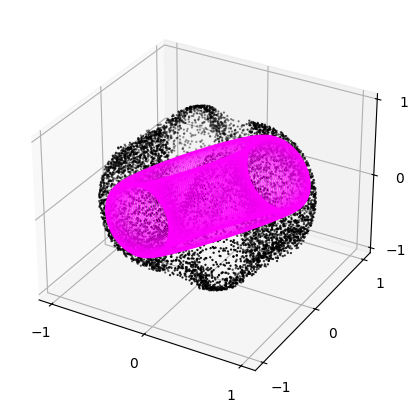

In [11]:
' LieDetect with T^2 '

# Find frequencies
dim = 2
frequency_max = 1
optimal_rep, optimal_algebra = find_closest_algebra(group="torus", lie_pca=lie_pca, group_dim=dim,
                                                    frequency_max=frequency_max, span_ambient_space=True,
                                                    method="abelian", verbose=True)

# Generate estimated orbit
nb_points_orbit = 200 ** 2
x = pts_cluster[0]
orbit = sample_orbit_from_algebra(group="torus", rep_type=optimal_rep, algebra=optimal_algebra, x=x,
                                  nb_points=nb_points_orbit, method="uniform", verbose=False)

# Compute non-symmetric Hausdorff
hausdorff = scipy.spatial.distance.directed_hausdorff(pts_cluster, orbit)[0]
print('Non-symmetric Hausdorff distance from point cloud to estimated orbit:', round(hausdorff, 4))
hausdorff = scipy.spatial.distance.directed_hausdorff(orbit, pts_cluster)[0]
print('Non-symmetric Hausdorff distance from estimated orbit to point cloud:', round(hausdorff, 4))

# Plot orbit.
pca = sklearn.decomposition.PCA(n_components=3).fit(pts_cluster)
pts_cluster_pca = pca.transform(pts_cluster)
orbit_pca = pca.transform(orbit)
_, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.scatter(pts_cluster_pca[:, 0], pts_cluster_pca[:, 1], pts_cluster_pca[:, 2], c="black", s=0.4)
ax.scatter(orbit_pca[:, 0], orbit_pca[:, 1], orbit_pca[:, 2], c='magenta', s=0.1, alpha=0.75, marker="3")
plt.locator_params(nbins=4)
plt.show()
fig.savefig('figures/cyclooctane4_align_torus.png', dpi=fig.dpi, bbox_inches='tight');

----> Optimization problem via abelian method for torus  <----
The optimal rep found is ((1, 2),) with cost 8.560e-02.
Non-symmetric Hausdorff distance from point cloud to estimated orbit: 1.0163
Non-symmetric Hausdorff distance from estimated orbit to point cloud: 0.0935


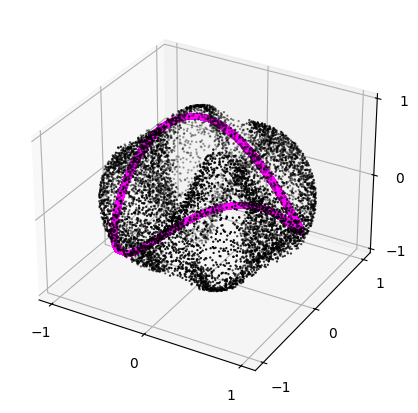

In [12]:
' LieDetect with SO(2) '

# Find frequencies
dim = 1
frequency_max = 2
optimal_rep, optimal_algebra = find_closest_algebra(group="torus", lie_pca=lie_pca, group_dim=dim,
                                                    frequency_max=frequency_max, span_ambient_space=True,
                                                    method="abelian", verbose=True)

# Generate estimated orbit
nb_points_orbit = 200 ** 2
x = pts_cluster[0]
orbit = sample_orbit_from_algebra(group="torus", rep_type=optimal_rep, algebra=optimal_algebra, x=x,
                                  nb_points=nb_points_orbit, method="uniform", verbose=False)

# Compute non-symmetric Hausdorff
hausdorff = scipy.spatial.distance.directed_hausdorff(pts_cluster, orbit)[0]
print('Non-symmetric Hausdorff distance from point cloud to estimated orbit:', round(hausdorff, 4))
hausdorff = scipy.spatial.distance.directed_hausdorff(orbit, pts_cluster)[0]
print('Non-symmetric Hausdorff distance from estimated orbit to point cloud:', round(hausdorff, 4))

# Plot orbit.
pca = sklearn.decomposition.PCA(n_components=3).fit(pts_cluster)
pts_cluster_pca = pca.transform(pts_cluster)
orbit_pca = pca.transform(orbit)
_, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.scatter(pts_cluster_pca[:, 0], pts_cluster_pca[:, 1], pts_cluster_pca[:, 2], c="black", s=0.4)
ax.plot(orbit_pca[:, 0], orbit_pca[:, 1], orbit_pca[:, 2], c='magenta', lw=4, alpha=0.75, marker="3")
plt.locator_params(nbins=4)
plt.show()
fig.savefig('figures/cyclooctane4_align.png', dpi=fig.dpi, bbox_inches='tight');

In [13]:
' Compute all Hausdorff distances '

distances = list()
for i in range(len(pts_cluster)):
    # Generate estimated orbit.
    nb_points_orbit = 100
    x = pts_cluster[i, :]
    orbit = sample_orbit_from_algebra(group="torus", rep_type=optimal_rep, algebra=optimal_algebra, x=x,
                                      nb_points=nb_points_orbit, method="uniform", verbose=False)
    # Compute non-symmetric Hausdorff distance.
    hausdorff = scipy.spatial.distance.directed_hausdorff(orbit, pts_cluster)[0]
    distances.append(hausdorff)

print('\nHausdorff distance mean, std and max:', np.mean(distances), np.std(distances), np.max(distances))


Hausdorff distance mean, std and max: 0.09043976624618594 0.026627364183202985 0.2563382483979725
